## Set up
### Importing libraries

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from itertools import combinations

### Data load & enrichment

In [104]:
data_folder = '.'

additional_features = pd.read_csv(f"{data_folder}/data.csv").drop("Id", axis=1)
additional_features = additional_features.fillna(additional_features.mean())
additional_features = additional_features.fillna('N/A')
base_features = pd.read_csv(f"{data_folder}/Houseprice_data_scaled.csv")
for c in base_features.columns:
    try:
        additional_features = additional_features.drop([c], axis=1)
    except KeyError:
        next

### Parameters & Constants

In [249]:
# Params
SHOW_CAT_TO_NUM_WARNING = False
ADDITIONAL_FEATURES_SELECT = ['MSSubClass', 'BsmtExposure']
LAMBDA_RIDGE = 0.16
LAMBDA_LASSO = 0.05
N_SIMULATIONS = 10000


# Constants
ADDITIONAL_FEATURES_FIXED = ['LotFrontage', 'LotShape']
ADDITIONAL_FEATURES = ADDITIONAL_FEATURES_FIXED + ADDITIONAL_FEATURES_SELECT
# Trying my damn best to natually map a categorical to numerical 
CAT_MAPS = {
    "LotShape": {
        "Reg": 3,
        "IR1": 2,
        "IR2": 1,
        "IR3": 0,
    },
    'MSZoning': {
        'A': 0,
        'I': 1,
        'FV': 2,
        'RH': 3,
        'RM': 4,
        'RL': 5,
        'RP': 6,
        'C': 7,
    },
    'Utilities': {
        'ELO': 0,
        'NoSeWa': 1,
        'NoSewr': 2,
        'AllPub': 3,
    },
    'LotConfig': {
        'Inside': 0,
        'Corner': 1,
        'CulDSac': 2,
        'FR2': 3,
        'FR3': 4,
    },
    'LandSlope': {
        'Gtl': 2,
        'Mod': 1,
        'Sev': 0,
    },
    'BldgType': {
        '1Fam': 4,
        '2FmCon': 3,
        'Duplx': 2,
        'TwnhsE': 1,
        'Twnhsl': 0,
    },
    'HouseStyle': {
        '1Story': 0,
        '1.5Unf': 1,
        '1.5Fin': 2,
        '2Story': 3,
        '2.5Unf': 4,
        '2.5Fin': 5,
        'SFoyer': 6,
        'SLvl': 7,
    },
    "ExterQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "ExterCond": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "BsmtQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "BsmtExposure": {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "NA": 0,
    },
    "BsmtFinType1": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "BsmtFinType2": {
        "GLQ": 6,
        "ALQ": 5,
        "BLQ": 4,
        "Rec": 3,
        "LwQ": 2,
        "Unf": 1,
        "NA": 0,
    },
    "HeatingQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Electrical": {
        "Sbrkr": 3,
        "FuseA": 2,
        "FuseF": 1,
        "FuseP": 0,
        "Mix": 1.5,
    },
    "KitchenQual": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "Functional": {
        "Min1": 6,
        "Min2": 5,
        "Mod": 4,
        "Maj1": 3,
        "Maj2": 2,
        "Sev": 1,
        "Sal": 0,
    },
    "FireplaceQu": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0,
    },
    "GarageType": {
        "NA": 0,
        "Attchd": 1,
        "Basment": 2,
        "BuiltIn": 3,
        "Carport": 4,
        "Detchd": 5,
        "2Types": 2.5,
    },
    "GarageFinish": {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0,
    },
    "GarageQual": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "GarageCond": {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "NA": 0,
    },
    "PavedDrive": {
        "Y": 2,
        "P": 1,
        "N": 0,
    },
    "PoolQC": {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "NA": 0,
    },
    "Fence": {
        "GdPrv": 4,
        "GdWo": 3,
        "MnPrv": 2,
        "MnWw": 1,
        "NA": 0,
    },
}

### Helper functions

In [256]:
def add_features(base, feature_name):
    """ 
    Outputs a dataframe which equals base_features plus any feature_name from additional_features. 
    Any categorical features will be naively converts to numerical values. All the feature values will be scaled.
    Any missing values (N/A) are filled with average values for this feature
    """
    rep_base = base.copy()
    def add_single_feature(single_feature):
        if is_numeric_dtype(additional_features[single_feature].dtype):
            rep_base[single_feature] = additional_features[single_feature]
        else:
            f_list = np.setdiff1d(additional_features[single_feature].unique(), ['N/A'])
            try:
                f_map = CAT_MAPS[single_feature]
            except KeyError:
#                 print("Warning: Can't find defined feature mapping for {} and it is automatically mapped to numerical".format(single_feature))
                f_map = dict(zip(f_list, range(len(f_list))))
            if SHOW_CAT_TO_NUM_WARNING:
                print("Warning: feature {} is categorical. Mapping to numerical...".format(single_feature))
                print("Mapping: {}".format(f_map))    
            rep_base[single_feature] = additional_features[single_feature].map(f_map)
            # TODO: what to do for NA in categorical features?
            rep_base[single_feature] = rep_base[single_feature].replace('N/A', np.nan)
            rep_base[single_feature] = rep_base[single_feature].fillna(rep_base[single_feature].mean())
        rep_base[single_feature] = (rep_base[single_feature] - rep_base[single_feature].mean()) / rep_base[single_feature].std()
    if type(feature_name) == str:
        add_single_feature(feature_name)
    else:
        for f in feature_name:
            add_single_feature(f)
    return rep_base

def split_dataset(dataset, k_fold=False):
    """ 
    Split input dataset into training, validation and test set (in this order) of size 1800, 600 and whatever left.
    In case of cross validation, train/val will be lists
    """
    idx_lst = np.arange(len(dataset))
    # Should really get rid of all the magic numbers
    if k_fold:
        np.random.shuffle(idx_lst)
        train_val_idx = idx_lst[:1800+600]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
        pods = []
        for i in range(4):
            pods.append(idx_lst[600*i:600*(i+1)])
        train = []
        val = []
        for i in range(4):
            val.append(dataset.iloc[pods[i]])
            train.append(dataset.iloc[np.concatenate([pods[j] for j in set(range(4)) - set([i])])])
    else:
        train = dataset.iloc[idx_lst[:1800]]
        val = dataset.iloc[idx_lst[1800:1800+600]]
        test = dataset.iloc[idx_lst[1800+600:len(dataset)]]
    return train, val, test

def split_xy(dataset, value_name="SalePrice"):
    """ Split input data set into feature and value """
    try:
        return dataset.drop(value_name, axis=1), dataset[[value_name]]
    except AttributeError:
        return [(d.drop(value_name, axis=1), d[[value_name]]) for d in dataset]

def regression(features, method='linear', alpha=0, cross_validation=None, cv_parameter=None):
    """ 
    Run a regression of choice with additional features added to base_features
    
    :param features: A list of features available in dataframe additional_features
    :param method: One of "linear", "ridge" or "lasso"
    :param alpha: Alpha pamameter used for ridge or lasso regression. Should be lambda in Hull's book times # of 
                  observations for ridge regression or half of lambda for lasso regression.
    :param random: Whether to split training/validation/test data sets randomly or not
    :param cross_validation: Method of cross validation. Only supports k-fold for now. If cross validation is used, output 
                             mse and coeffs are averaged results from cross validations
    :param cv_parameter: A tuple of numerical parameters used in cross validation. E.g. sample size p for training set in an
                         exhausive cross validation, or k in a k-fold.
    
    :return: A dictionary containing coeffients and model mse
    """
    # Select features
    df = add_features(base_features, list(features))
    
    # Split data set and split each into X and y where y is the price, and X is set of features
    train, val, test = [split_xy(x) for x in split_dataset(df, k_fold=(cross_validation == 'k-fold'))]
    
    # Fit model
    def fit_model(train_set, val_set, alpha):
        reg_model = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=alpha),
            'lasso': Lasso(alpha=alpha),
        }[method.lower()]
        reg_model.fit(*train_set)
    
        return {
            'coeffs': pd.DataFrame(
                [
                    ['intercept'] + list(train_set[0]),
                    list(reg_model.intercept_) + list(reg_model.coef_ if method == 'lasso' else reg_model.coef_[0])
                ]
            ).transpose().set_index(0),
            'mse': mse(val_set[1], reg_model.predict(val_set[0])),
            'reg_model': reg_model,
            'test_set': test,
        }
    
    def with_cv(alpha):
        coeffs = []
        mse = []
        if cross_validation == 'k-fold':
            for i in range(len(train)):
                rs = fit_model(train[i], val[i], alpha)
                coeffs.append(rs['coeffs'])
                mses.append(rs['mse'])
            return {
                'coeffs': pd.DataFrame(pd.concat(coeffs, axis=1).mean(axis=1)),
                'mse': np.array(mses).mean(),
                'reg_model': rs['reg_model'],
                'test_set': test,
            }
        else:
            return fit_model(train, val, alpha)
    
    try:
        return with_cv(float(alpha))
    except TypeError:
        return [with_cv(float(a)) for a in alpha]


## Feature Selections
First, use lasso on all the feature, and only look at features that survived lasso.  
Then, for a fixed alpha level, select two features that minimizes mse using either linear, ridge or lasso regression  
Using ridge below since ridge in general gives a lower MSE than lasso  

We can see that a few important features popped out, e.g.
* BsmtExposure
* MSSubClass
* ExterQual

We will use *BsmtExposure* and *MSSubClass* together with *LotShape* and *LotFrontage* as additional features

In [250]:
# Assumes all the features are added. Look at what are the non zero features after lasso
tmp = regression(list(set(additional_features.columns) - set(['SalePrice'])), method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']
ok_features = []
for i in tmp[abs(tmp[1]) > 0.01].index:
    if i in additional_features.columns:
        ok_features.append(i)
tmp = []
for i in fdf.iterrows():
    if i[1]['feature 1'] in ok_features and i[1]['feature 2'] in ok_features:
        tmp.append(i[1])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(tmp).sort_values(by='mse'))

         feature 1      feature 2       mse
1063  BsmtExposure     MSSubClass  0.100395
1060     ExterQual     MSSubClass  0.101371
3073     ExterQual   BsmtExposure  0.101449
2923    MasVnrArea      ExterQual  0.103134
1046    MasVnrArea     MSSubClass  0.104269
996      ExterQual   GarageFinish  0.104384
2926    MasVnrArea   BsmtExposure  0.104837
1753   KitchenQual   BsmtExposure  0.105109
591      ExterQual  SaleCondition  0.105245
1012   KitchenQual     MSSubClass  0.105261
1750     ExterQual    KitchenQual  0.105388
936   GarageFinish     MSSubClass  0.105784
1123     ExterQual   KitchenAbvGr  0.105892
1126  BsmtExposure   KitchenAbvGr  0.106287
1736    MasVnrArea    KitchenQual  0.106497
999   GarageFinish   BsmtExposure  0.106545
594   BsmtExposure  SaleCondition  0.106642
531     MSSubClass  SaleCondition  0.106704
982     MasVnrArea   GarageFinish  0.107728
2985    MasVnrType      ExterQual  0.107954
1001  KitchenAbvGr     MSSubClass  0.108011
577     MasVnrArea  SaleConditio

## Regression Analysis I

Use first 1800 as training set, next 800 as validation set and the rest as test set  

### Linear Regression

In [251]:
regression(ADDITIONAL_FEATURES, method='linear')['coeffs']

,1
0,
intercept,-0.0129841
LotArea,0.0548508
OverallQual,0.201903
OverallCond,0.0862596
YearBuilt,0.149553
YearRemodAdd,0.0263949
BsmtFinSF1,0.100484
BsmtUnfSF,-0.0178654
TotalBsmtSF,0.106853


### Ridge Regression

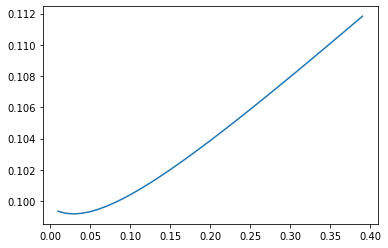

,1
0,
intercept,-0.0129029
LotArea,0.0470686
OverallQual,0.177341
OverallCond,0.0623393
YearBuilt,0.0857532
YearRemodAdd,0.0511777
BsmtFinSF1,0.0974717
BsmtUnfSF,-0.00991339
TotalBsmtSF,0.092521


In [252]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

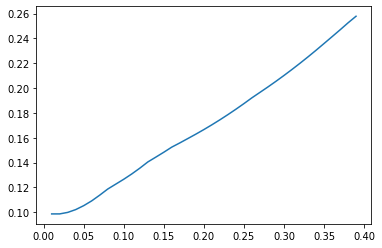

,1
0,
intercept,-0.0121483
LotArea,0.043024
OverallQual,0.256619
OverallCond,0.0305921
YearBuilt,0.0872562
YearRemodAdd,0.0524516
BsmtFinSF1,0.111113
BsmtUnfSF,-0
TotalBsmtSF,0.0855628


In [253]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']


### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [260]:
rs_1 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800)
coeffs_1 = rs_1['coeffs']
mse_1 = mse(rs_1['test_set'][1], rs_1['reg_model'].predict(rs_1['test_set'][0]))

print(f"MSE on test set: {mse_1}")
coeffs_1

MSE on test set: 0.10543716359567239


,1
0,
intercept,-0.0130021
LotArea,0.0491799
OverallQual,0.185884
OverallCond,0.0686587
YearBuilt,0.0974493
YearRemodAdd,0.0456029
BsmtFinSF1,0.0997122
BsmtUnfSF,-0.0117032
TotalBsmtSF,0.0946125


## Regression Analysis II

Randomly determine training set, validation set and test set  
Perform k-fold cross-validatoin and take the average for MSE and coefficients. In this case we will use $k=4$ since we have set validation set to have 600 records and training set + validation set has 2400 records. 

### Linear Regression

In [239]:
regression(ADDITIONAL_FEATURES, method='linear', cross_validation='k-fold')['coeffs']

,0
0,
intercept,-1.182515e-03
LotArea,5.560117e-02
OverallQual,2.066763e-01
OverallCond,7.477133e-02
YearBuilt,1.367123e-01
YearRemodAdd,3.781315e-02
BsmtFinSF1,8.134929e-02
BsmtUnfSF,-4.849775e-02
TotalBsmtSF,1.262198e-01


### Ridge Regression

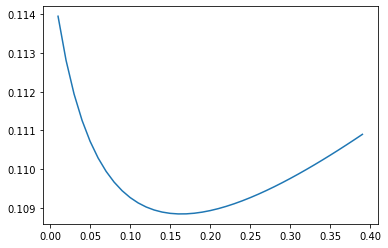

,0
0,
intercept,0.000015
LotArea,0.035768
OverallQual,0.130865
OverallCond,0.025341
YearBuilt,0.058521
YearRemodAdd,0.062369
BsmtFinSF1,0.077052
BsmtUnfSF,-0.002459
TotalBsmtSF,0.082501


In [246]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='ridge', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')['coeffs']

### Lasso Regression

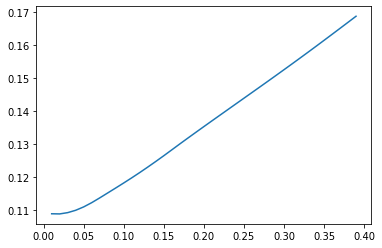

,0
0,
intercept,-0.001617
LotArea,0.039877
OverallQual,0.250708
OverallCond,0.040962
YearBuilt,0.092525
YearRemodAdd,0.051572
BsmtFinSF1,0.117588
BsmtUnfSF,-0.000000
TotalBsmtSF,0.078796


In [248]:
lambdas = np.arange(0.01, 0.4, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES, method='lasso', alpha=alphas, cross_validation='k-fold')]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES, method='lasso', alpha=LAMBDA_LASSO/2, cross_validation='k-fold')['coeffs']

### Use Ridge Regression on Test set

$\lambda$ set to 0.16

In [259]:
rs_2 = regression(ADDITIONAL_FEATURES, method='ridge', alpha=LAMBDA_RIDGE*1800, cross_validation='k-fold')
coeffs_2 = rs_2['coeffs']
mse_2 = mse(rs_2['test_set'][1], rs_2['reg_model'].predict(rs_2['test_set'][0]))

print(f"MSE on test set: {mse_2}")
coeffs_2

MSE on test set: 0.08747287187219531


,0
0,
intercept,-0.001658
LotArea,0.041587
OverallQual,0.184805
OverallCond,0.062258
YearBuilt,0.085796
YearRemodAdd,0.057423
BsmtFinSF1,0.098815
BsmtUnfSF,-0.017313
TotalBsmtSF,0.098926


## Observations
A good observation is that as lambda level increases, the average magnitude of coefficients decreases in ridge and lasso regression

Average magnitude of coefficients vs lambda level

Ridge Regression


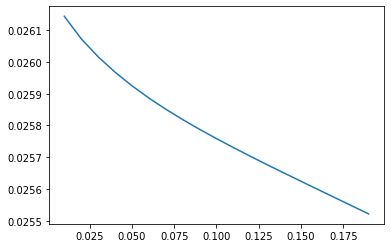

Lasso Regression


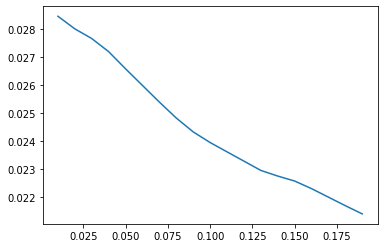

In [122]:
# Yvonne's for loop

lambdas = np.arange(0.01, 0.2, 0.01)
alphas = {'ridge': lambdas * 1800, 'lasso': lambdas / 2}

print("Average magnitude of coefficients vs lambda level\n")
for m in ['ridge', 'lasso']: 
    print(f'{m.capitalize()} Regression')
    plt.plot(lambdas, [float(shit['coeffs'].mean()) for shit in regression(ADDITIONAL_FEATURES_SELECT2, method=m, alpha=alphas[m])])
    plt.show()